In [ ]:
"""
Compute efficiency multipliers using the by-loss method and recreate the
bar chart from alg_mult_error_bar.py with the new metric.

This script mirrors the comparisons/plotting of alg_mult_error_bar.py, but
each multiplier is computed as the ratio of compute needed to reach the same
target validation loss (Model B / Model A), aggregated across matching seeds
when available.

Available Functions:
--------------------
1. compute_multiplier_by_loss: Compare two empirical training curves at a target loss
2. compute_multiplier_closest_approach: Compare an empirical curve to a power law fit
   at the point of closest approach (minimum x-axis distance)
"""

In [5]:
import os
import re
import glob
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import util as _importlib_util

In [ ]:

# Robust loader to access compute_multiplier_by_loss without static imports


def _get_compute_multiplier_functions():
    """Import both compute_multiplier_by_loss and compute_multiplier_closest_approach."""
    try:
        # Try importing as package module
        import importlib

        module = importlib.import_module(
            "experimental_analysis.compute_multiplier_by_loss"
        )
        return (
            getattr(module, "compute_multiplier_by_loss"),
            getattr(module, "compute_multiplier_closest_approach"),
        )
    except Exception:
        # Load directly from file path (same directory)
        candidate = os.path.join(
            os.path.dirname(__file__), "compute_multiplier_by_loss.py"
        )
        spec = _importlib_util.spec_from_file_location(
            "compute_multiplier_by_loss", candidate
        )
        if spec is None or spec.loader is None:
            raise ImportError(
                "Unable to locate compute_multiplier_by_loss.py in experimental_analysis/"
            )
        module = _importlib_util.module_from_spec(spec)
        spec.loader.exec_module(module)  # type: ignore[attr-defined]
        return (
            getattr(module, "compute_multiplier_by_loss"),
            getattr(module, "compute_multiplier_closest_approach"),
        )


# Bind the function names used below
compute_multiplier_by_loss, compute_multiplier_closest_approach = (
    _get_compute_multiplier_functions()
)

In [ ]:

# ===== EASILY ADJUSTABLE PARAMETERS =====
TARGET_LOSS = 5.33  # Target validation loss at which to compare compute
LOSS_COLUMN = "validation_loss"
CONFIDENCE_INTERVALS = False  # Set to True to display error bars

# Plot font sizes (kept consistent with alg_mult_error_bar.py)
TITLE_FONTSIZE = 20
AXIS_LABEL_FONTSIZE = 20
X_TICK_LABEL_FONTSIZE = 12
Y_TICK_LABEL_FONTSIZE = 16
LEGEND_FONTSIZE = 15
VALUE_LABEL_FONTSIZE = 12
X_TICK_ROTATION = 45


def _get_base_data_path() -> str:
    """Return base path to experimental data, compatible with both run locations."""
    if os.path.exists("../experimental_data_folder/"):
        return "../experimental_data_folder/"
    return "experimental_data_folder/"


def _collect_seeded_files(file_prefix: str) -> Dict[Optional[int], List[str]]:
    """
    Collect CSV files for a given prefix and group them by numeric seed suffix.

    A file is considered seed-tagged if it ends with _<digits>.csv. Files without
    such a suffix are grouped under key None.
    """
    base_path = _get_base_data_path()
    pattern = f"{base_path}{file_prefix}*.csv"
    all_files = glob.glob(pattern)

    seed_regex = re.compile(r"_(\d+)\.csv$")
    grouped: Dict[Optional[int], List[str]] = {}

    for path in all_files:
        match = seed_regex.search(path)
        if match:
            seed = int(match.group(1))
        else:
            seed = None
        grouped.setdefault(seed, []).append(path)

    return grouped


def _pair_seed_files(prefix_a: str, prefix_b: str) -> List[Tuple[str, str]]:
    """
    Pair files from two prefixes by matching seed ids when available.

    Priority:
    - If there are common numeric seeds, pair those (one file per seed per side; if
      multiple files per seed, take them all cross-product).
    - Else, if both sides have only unseeded files (key None), pair them one-to-one
      in sorted order by filename up to min length.
    - Else, if one side has seeded and the other does not, pair unseeded files with
      all seeded files (best-effort pairing).
    """
    grouped_a = _collect_seeded_files(prefix_a)
    grouped_b = _collect_seeded_files(prefix_b)

    seeds_a = set(grouped_a.keys())
    seeds_b = set(grouped_b.keys())

    common_numeric_seeds = [s for s in seeds_a.intersection(seeds_b) if s is not None]

    pairs: List[Tuple[str, str]] = []

    if len(common_numeric_seeds) > 0:
        common_numeric_seeds.sort()
        for s in common_numeric_seeds:
            for fa in sorted(grouped_a.get(s, [])):
                for fb in sorted(grouped_b.get(s, [])):
                    pairs.append((fa, fb))
        return pairs

    # Fallbacks when no common numeric seeds
    files_a_none = sorted(grouped_a.get(None, []))
    files_b_none = sorted(grouped_b.get(None, []))

    if len(files_a_none) > 0 and len(files_b_none) > 0:
        # Pair in order
        for fa, fb in zip(files_a_none, files_b_none):
            pairs.append((fa, fb))
        return pairs

    # Mixed case: one side has seeds, the other does not
    if len(files_a_none) > 0 and len(grouped_b) > 0:
        seeded_b = [f for s, fs in grouped_b.items() if s is not None for f in fs]
        for fa in files_a_none:
            for fb in sorted(seeded_b):
                pairs.append((fa, fb))
        return pairs

    if len(files_b_none) > 0 and len(grouped_a) > 0:
        seeded_a = [f for s, fs in grouped_a.items() if s is not None for f in fs]
        for fb in files_b_none:
            for fa in sorted(seeded_a):
                pairs.append((fa, fb))
        return pairs

    return pairs


def compute_multiplier_estimate_by_loss(
    base_loss_prefix: str,
    second_loss_prefix: str,
    target_loss: float,
    loss_column: str = LOSS_COLUMN,
    verbose: bool = False,
) -> Tuple[Optional[float], Optional[float]]:
    """
    Compute the mean by-loss multiplier and its 95% CI across paired files.

    Returns (mean_multiplier, error_bar) or (None, None) if no pairs found.
    """
    pairs = _pair_seed_files(base_loss_prefix, second_loss_prefix)

    if verbose:
        print(
            f"\nPairing for prefixes '{base_loss_prefix}' vs '{second_loss_prefix}': {len(pairs)} pairs"
        )
        for a, b in pairs[:5]:
            print(f"  {os.path.basename(a)}  <->  {os.path.basename(b)}")
        if len(pairs) > 5:
            print("  ...")

    if len(pairs) == 0:
        print(
            f"No paired files found for prefixes '{base_loss_prefix}' and '{second_loss_prefix}'."
        )
        return None, None

    multipliers: List[float] = []
    for file_a, file_b in pairs:
        try:
            mult, _ = compute_multiplier_by_loss(
                file_a,
                file_b,
                target_loss=target_loss,
                loss_column=loss_column,
                verbose=False,
            )
            if np.isfinite(mult):
                multipliers.append(float(mult))
        except Exception as e:
            if verbose:
                print(f"  Skipping pair due to error: {e}")
            continue

    if len(multipliers) == 0:
        print(
            f"No valid multipliers computed for '{base_loss_prefix}' vs '{second_loss_prefix}'."
        )
        return None, None

    mean_multiplier = float(np.mean(multipliers))
    # 95% CI using standard error
    if len(multipliers) > 1:
        error_bar = float(
            np.std(multipliers, ddof=1) / np.sqrt(len(multipliers)) * 1.96
        )
    else:
        error_bar = 0.0

    return mean_multiplier, error_bar

In [8]:
# Setup plotting style and parameters
sns.set_style("ticks")

# ===== EASILY ADJUSTABLE PARAMETERS =====
confidence_intervals = CONFIDENCE_INTERVALS  # Set to False to hide error bars

# ===== EASILY ADJUSTABLE FONT SIZES =====
title_fontsize = TITLE_FONTSIZE
axis_label_fontsize = AXIS_LABEL_FONTSIZE
x_tick_label_fontsize = X_TICK_LABEL_FONTSIZE
y_tick_label_fontsize = Y_TICK_LABEL_FONTSIZE
legend_fontsize = LEGEND_FONTSIZE
value_label_fontsize = VALUE_LABEL_FONTSIZE
x_tick_rotation = X_TICK_ROTATION

In [37]:
# Compute by-loss multipliers (paired across seeds when available)
# swiglu_gelu_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_adam", "stanford_mult/64d_gelu", target_loss=TARGET_LOSS
# )

swiglu_gelu_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_gelu", target_loss=TARGET_LOSS
)
print(swiglu_gelu_estimate)

(1.0927672955974843, 0.0)


In [ ]:
swiglu_relu_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_adam", "stanford_mult/64d_relu", target_loss=TARGET_LOSS
)
print(swiglu_relu_estimate)

(1.0705035971223023, 0.0)


In [11]:
swiglu_gelu_ff4_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_gelu_ff4", target_loss=TARGET_LOSS
)
print(swiglu_gelu_ff4_estimate)

(0.9901685393258427, 0.0)


In [39]:


gelu_relu_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_gelu", "all_ablations/64d_relu", target_loss=TARGET_LOSS
)
print(gelu_relu_estimate)

(1.0474820143884893, 0.0)


In [13]:
# rotary vs sinusoidal (compute and print, but keep manual override in plot if desired)
rotary_sinusoidal_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_sinusoidal", target_loss=TARGET_LOSS
)
print(rotary_sinusoidal_estimate)

(1.2696629213483146, 0.0)


### Rotary Encodings

In [14]:
rotary_learned_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_learned", target_loss=TARGET_LOSS
)
print(rotary_learned_estimate)

(1.1867977528089888, 0.0)


In [15]:
# rotary vs learned
rotary_sinusoidal_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_sinusoidal", target_loss=TARGET_LOSS
)
print(rotary_sinusoidal_estimate)

(1.2696629213483146, 0.0)


### Normalization Estimates

In [42]:
# post vs pre norm
post_pre_norm_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_post", target_loss=TARGET_LOSS
)
print(post_pre_norm_estimate)

rms_vs_layer_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_layer", target_loss=TARGET_LOSS
)
print(rms_vs_layer_estimate)

(1.9025157232704402, 0.0)
(1.0534591194968554, 0.0)


In [17]:
# adam vs sgd estimate at bs64
adam_sgd_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms",
    "new_sgd_scaling/64d_sgdbs64",
    target_loss=TARGET_LOSS,
)
print(adam_sgd_estimate)

(3.103932584269663, 0.0)


In [43]:
# estimate of cosine warmup vs inverse_sqrt
cosine_inverse_sqrt_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "all_ablations/64d_lr_inverse_sqrt",
    target_loss=TARGET_LOSS,
)
print(cosine_inverse_sqrt_estimate)

(1.0534591194968554, 0.0)


In [19]:
cosine_v_linear_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_linear_warmup", target_loss=TARGET_LOSS
)
print(cosine_v_linear_estimate)

(0.9873595505617978, 0.0)


In [33]:
# compare lstm to modern transformer
# TARGET_LOSS = 5.33
# lstm_modern_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_rms",
#     "/lstm_layer1/80d",
#     target_loss=TARGET_LOSS,
# )


TARGET_LOSS = 5.33
lstm_modern_transformer_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "/lstm_layer1/80d",
    target_loss=TARGET_LOSS,
)
print(lstm_modern_transformer_estimate)

(6.179245283018868, 0.0)


In [32]:

# lstm to old transforem
# lstm_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "debug_historical_experiments/radford_64transformer_2018_bs64",
#     "/lstm_layer1/80d",
#     target_loss=TARGET_LOSS,
# )

lstm_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
    "retry_historical_experiments/64_all_reset",
    "/lstm_layer1/80d",
    target_loss=TARGET_LOSS,
)
print(lstm_historical_transformer_estimate)

(3.3879310344827585, 0.0)


In [ ]:

# TARGET_LOSS = 5.33
# # modern 0 bias
# modern_0_bias_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_swiglu",
#     "stanford_mult/64d_removing_bias",
#     target_loss=TARGET_LOSS,
# )
# print(modern_0_bias_estimate)

(0.9046941678520626, 0.0)


In [23]:


#adamw vs adam 



In [ ]:
TARGET_LOSS = 5.33
# modern to historical transformer
# modern_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_rms",
#     "debug_historical_experiments/radford_64transformer_2018_bs64",
#     target_loss=TARGET_LOSS,
# )

modern_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms",
    "retry_historical_experiments/64_all_reset",
    target_loss=TARGET_LOSS,
)

modern_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms",
    "retry_historical_experiments/64_all_reset",
    target_loss=TARGET_LOSS,
)
print(modern_historical_transformer_estimate)

(1.6292134831460674, 0.0)


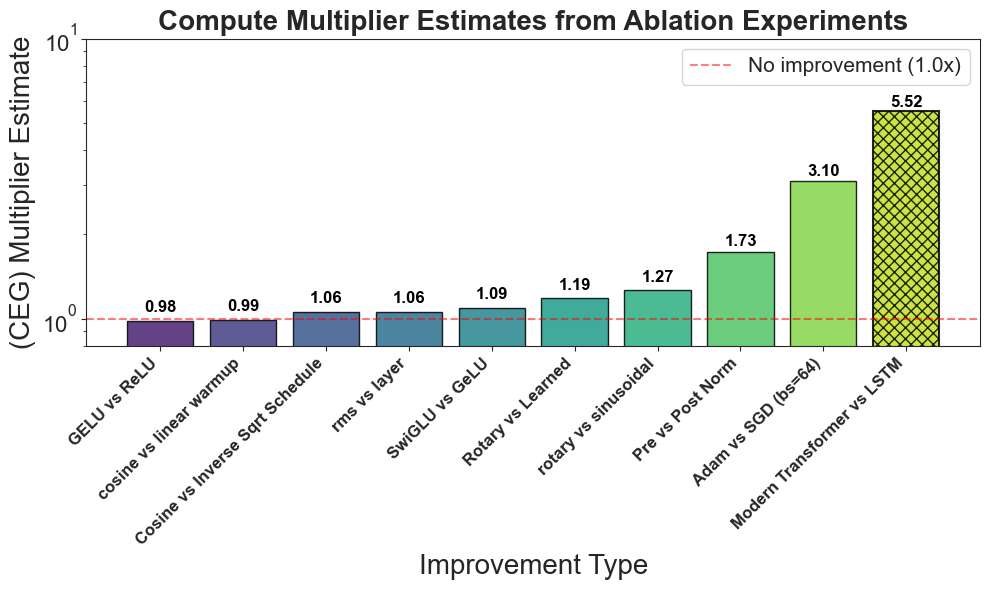


Summary of Compute Multiplier (by-loss) Estimates:
GELU vs ReLU: 0.978x (-2.3% compute efficiency)
cosine vs linear warmup: 0.987x (-1.3% compute efficiency)
Cosine vs Inverse Sqrt Schedule: 1.058x (+5.8% compute efficiency)
rms vs layer: 1.058x (+5.8% compute efficiency)
SwiGLU vs GeLU: 1.095x (+9.5% compute efficiency)
Rotary vs Learned: 1.187x (+18.7% compute efficiency)
rotary vs sinusoidal: 1.270x (+27.0% compute efficiency)
Pre vs Post Norm: 1.728x (+72.8% compute efficiency)
Adam vs SGD (bs=64): 3.104x (+210.4% compute efficiency)
Modern Transformer vs LSTM: 5.520x (+452.0% compute efficiency)


In [31]:
# Create bar plot of compute multiplier estimates with error bars
estimates_data = [
    # ("Rotary vs Learned", rotary_learned_estimate)
    ("Rotary vs Learned", rotary_learned_estimate),  # manual override retained
    ("SwiGLU vs GeLU", swiglu_gelu_estimate),  # manual override retained
    ("GELU vs ReLU", gelu_relu_estimate),
    ("Modern Transformer vs LSTM", lstm_modern_transformer_estimate),
    ("Cosine vs Inverse Sqrt Schedule", cosine_inverse_sqrt_estimate),
    # ("Cosine Warmup vs Linear", cosine_v_linear_estimate),
    ("Adam vs SGD (bs=64)", adam_sgd_estimate),
    ("Pre vs Post Norm", post_pre_norm_estimate),
    ("rotary vs sinusoidal", rotary_sinusoidal_estimate),
    ("rms vs layer", rms_vs_layer_estimate),
    ("cosine vs linear warmup", cosine_v_linear_estimate),
]

CROSS_HATCH_LABEL = "Modern Transformer vs LSTM"


# Filter out None estimates and separate labels, multipliers, and error bars
valid_estimates = [
    (label, data) for label, data in estimates_data if data[0] is not None
]

if valid_estimates:
    # Sort by multiplier so that the highest bar is on the right
    valid_estimates_sorted = sorted(valid_estimates, key=lambda x: x[1][0])

    labels = [item[0] for item in valid_estimates_sorted]
    multipliers = [item[1][0] for item in valid_estimates_sorted]
    error_bars = [item[1][1] for item in valid_estimates_sorted]

    # Choose color palette length to match number of bars (repeat if more than 3)
    palette = sns.color_palette("viridis", n_colors=len(labels))
    bar_colors = palette[: len(labels)]

    plt.figure(figsize=(10, 6))

    # Conditionally add error bars based on confidence_intervals parameter
    if confidence_intervals:
        bars = plt.bar(
            labels,
            multipliers,
            yerr=error_bars,
            capsize=5,
            color=bar_colors,
            alpha=0.85,
            edgecolor="black",
            linewidth=1,
        )
    else:
        bars = plt.bar(
            labels,
            multipliers,
            color=bar_colors,
            alpha=0.85,
            edgecolor="black",
            linewidth=1,
        )
    
    # Apply cross hatching to specified bar if CROSS_HATCH_LABEL is set
    if CROSS_HATCH_LABEL is not None:
        try:
            hatch_idx = labels.index(CROSS_HATCH_LABEL)
            bars[hatch_idx].set_hatch('xxx')  # Cross hatch pattern
            bars[hatch_idx].set_edgecolor('black')
            bars[hatch_idx].set_linewidth(1.5)  # Slightly thicker edge for visibility
        except ValueError:
            print(f"Warning: Label '{CROSS_HATCH_LABEL}' not found in labels. Available labels: {labels}")

    plt.ylabel("(CEG) Multiplier Estimate", fontsize=axis_label_fontsize)
    plt.xlabel("Improvement Type", fontsize=axis_label_fontsize)
    plt.title(
        "Compute Multiplier Estimates from Ablation Experiments",
        fontsize=title_fontsize,
        fontweight="bold",
    )
    # Increase the font size of the x-tick labels for visibility
    plt.xticks(
        rotation=x_tick_rotation,
        ha="right",
        fontsize=x_tick_label_fontsize,  # Use separate parameter
        fontweight="bold",
    )

    # Fix y-axis tick label sizes for log scale
    ax = plt.gca()
    ax.tick_params(axis="y", which="major", labelsize=y_tick_label_fontsize)
    ax.tick_params(axis="y", which="minor", labelsize=y_tick_label_fontsize)

    plt.grid(axis="y", alpha=0.3, linestyle="--")

    # Add value labels on top of bars
    for i, (bar, multiplier, error) in enumerate(zip(bars, multipliers, error_bars)):
        if confidence_intervals:
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height() + error + 0.05,
                f"{multiplier:.2f}±{error:.2f}",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
                color="black",
            )
        else:
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height() + 0.05,
                f"{multiplier:.2f}",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
                color="black",
            )

    # Set log scale before setting limits
    plt.yscale("log")

    # Add a horizontal line at y=1 for reference (no improvement)
    plt.axhline(
        y=1, color="red", linestyle="--", alpha=0.5, label="No improvement (1.0x)"
    )

    # Set y-axis limits appropriate for log scale (cannot start at 0)
    plt.ylim(0.8, 10)
    plt.legend(fontsize=legend_fontsize)

    plt.tight_layout()

    # Create Figures directory if it doesn't exist
    os.makedirs("Figures", exist_ok=True)

    # Save the figure
    plt.savefig(
        "Figures/compute_multiplier_estimates.png", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "Figures/compute_multiplier_estimates.pdf", bbox_inches="tight"
    )  # Also save as PDF

    plt.show()

    # Print summary
    print("\nSummary of Compute Multiplier (by-loss) Estimates:")
    print("=" * 50)
    for label, multiplier, error in zip(labels, multipliers, error_bars):
        improvement = (
            ((multiplier - 1) * 100)
            if multiplier > 1
            else (-(1 / multiplier - 1) * 100)
        )
        if confidence_intervals:
            print(
                f"{label}: {multiplier:.3f}x"
                + (f" ± {error:.3f}" if error is not None else "")
                + f" ({improvement:+.1f}% compute efficiency)"
            )
        else:
            print(
                f"{label}: {multiplier:.3f}x ({improvement:+.1f}% compute efficiency)"
            )
else:
    print("No valid estimates found to plot.")

In [ ]:
# Example usage of compute_multiplier_closest_approach
# This compares an empirical training curve to a power law fit

# # Example: Compare an empirical run to a fitted scaling law
# # Power law form: Loss = E + A * C^(-alpha)
#
# # Step 1: Define your power law parameters (from fitting your scaling data)
# E = 3.5  # Irreducible loss
# A = 1e14  # Amplitude
# alpha = 0.05  # Exponent
#
# # Step 2: Path to your empirical CSV file
# csv_file = _get_base_data_path() + "stanford_mult/64d_rms.csv"
#
# # Step 3: Compute the multiplier at closest approach
# multiplier, details = compute_multiplier_closest_approach(
#     csv_file=csv_file,
#     E=E,
#     A=A,
#     alpha=alpha,
#     compute_column="total_flops_profiler",
#     loss_column="validation_loss",
#     verbose=True
# )
#
# print(f"\n{'='*60}")
# print(f"Multiplier at closest approach: {multiplier:.3f}x")
# print(f"Closest approach validation loss: {details['closest_approach']['loss']:.4f}")
# print(f"Empirical compute: {details['closest_approach']['empirical_compute']:.2e} FLOPs")
# print(f"Power law compute: {details['closest_approach']['powerlaw_compute']:.2e} FLOPs")